# Run the blocks of code below to start processing of streaming data

In [1]:
#import needed libraries 

import re
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

In [2]:
#define needed functions

def updateFunc(newValues, runningCount):
    if runningCount is None:
        runningCount = 0
    return sum(newValues, runningCount)

def f1drivers(word):
    drivers = ['bottas', 'zhou', 'gasly', 'tsunoda', 'alonso', 'ocon', 'vettel', 'stroll', 
     'leclerc', 'sainz', 'schumacher', 'magnussen', 'ricciardo', 'norris', 'hamilton', 
     'russell', 'verstappen', 'pérez', 'albon', 'latifi'] 
    return word.lower() in drivers

In [3]:
#Create a function to write streaming data into csv

from pyspark.sql import Row, SQLContext
import pandas as pd

def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']
def process(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        # Get spark sql singleton context from the current context
        sql_context = get_sql_context_instance(rdd.context)
        
        # convert the RDD to Row RDD
        row_rdd = rdd.map(lambda w: Row(Driver=w[0], Total_number=w[1]))
        
        # create a DF from the Row RDD
        word_df = sql_context.createDataFrame(row_rdd)
        
        # Register the dataframe as table
        word_df.registerTempTable("words")
        
        # Convert spart DF to Pandas DF 
        pandas_df = word_df.select("*").toPandas()
        
        # Print data in pandas DF
        print(pandas_df)
        
        # Save pandas_df to CSV file
        pandas_df.to_csv('Counting_Results.csv')
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

In [4]:
#setup SparkContext and StreamingContext
sc = SparkContext("local[2]", "NetworkWordCount")
sc.setLogLevel("ERROR")
ssc = StreamingContext(sc, 5)
ssc.checkpoint("checkpoint_directory")

#collect tweets from localhost
lines = ssc.socketTextStream("localhost", 9008)

# split each line into words, DStream (lines) is mapped to another DStream (words)
words = lines\
.flatMap(lambda lines: lines.split(" "))\
.filter(lambda x: f1drivers(x)).map(lambda word: (word.capitalize(), 1))
#.filter(lambda lines: '#driveroftheday' in lines)\ 
#the line above is commented so there are more tweets (when no race is in progress)

#sum and print the results on the screen
runningCounts = words.updateStateByKey(updateFunc)
runningCounts.pprint()

# do processing for each RDD generated in each interval, save to CSV file
runningCounts.foreachRDD(process)


ssc.start()             # Start the computation
ssc.awaitTermination()  # Wait for the computation to terminate
ssc.stop(True,True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/08 18:30:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-------------------------------------------
Time: 2022-10-08 18:31:00
-------------------------------------------

----------- 2022-10-08 18:31:00 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
22/10/08 18:31:02 ERROR JobScheduler: Error running job streaming job 1665246660000 ms.1
org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/var/folders/k4/czzmds1d2yz83sv2728160680000gn/T/ipykernel_3538/1213598798.py", line 20, in process
    word_df = sql_context.createDataFrame(row_rdd)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py", line 373, in createDataFrame
    return self.sparkSession.createDataFrame(data, schema, samplingRatio, verifySchema)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 675, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 698, in _create_datafra

Py4JJavaError: An error occurred while calling o24.awaitTermination.
: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/var/folders/k4/czzmds1d2yz83sv2728160680000gn/T/ipykernel_3538/1213598798.py", line 20, in process
    word_df = sql_context.createDataFrame(row_rdd)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py", line 373, in createDataFrame
    return self.sparkSession.createDataFrame(data, schema, samplingRatio, verifySchema)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 675, in createDataFrame
    return self._create_dataframe(data, schema, samplingRatio, verifySchema)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 698, in _create_dataframe
    rdd, schema = self._createFromRDD(data.map(prepare), schema, samplingRatio)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 486, in _createFromRDD
    struct = self._inferSchema(rdd, samplingRatio, names=schema)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/session.py", line 460, in _inferSchema
    first = rdd.first()
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/rdd.py", line 1591, in first
    raise ValueError("RDD is empty")
ValueError: RDD is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/streaming/util.py", line 68, in call
    r = self.func(t, *rdds)
  File "/var/folders/k4/czzmds1d2yz83sv2728160680000gn/T/ipykernel_3538/1213598798.py", line 35, in process
    e = sys.exc_info()[0]
NameError: name 'sys' is not defined

	at org.apache.spark.streaming.api.python.TransformFunction.callPythonTransformFunction(PythonDStream.scala:95)
	at org.apache.spark.streaming.api.python.TransformFunction.apply(PythonDStream.scala:78)
	at org.apache.spark.streaming.api.python.PythonDStream$.$anonfun$callForeachRDD$1(PythonDStream.scala:179)
	at org.apache.spark.streaming.api.python.PythonDStream$.$anonfun$callForeachRDD$1$adapted(PythonDStream.scala:179)
	at org.apache.spark.streaming.dstream.ForEachDStream.$anonfun$generateJob$2(ForEachDStream.scala:51)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.streaming.dstream.DStream.createRDDWithLocalProperties(DStream.scala:417)
	at org.apache.spark.streaming.dstream.ForEachDStream.$anonfun$generateJob$1(ForEachDStream.scala:51)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.streaming.scheduler.Job.run(Job.scala:39)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler.$anonfun$run$1(JobScheduler.scala:256)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at org.apache.spark.streaming.scheduler.JobScheduler$JobHandler.run(JobScheduler.scala:256)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


-------------------------------------------
Time: 2022-10-08 18:31:05
-------------------------------------------
('Norris', 1)
('Verstappen', 1)
('Ricciardo', 1)

----------- 2022-10-08 18:31:05 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             1
2   Ricciardo             1


-------------------------------------------
Time: 2022-10-08 18:31:10
-------------------------------------------
('Norris', 1)
('Verstappen', 1)
('Ricciardo', 1)

----------- 2022-10-08 18:31:10 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             1
2   Ricciardo             1


-------------------------------------------
Time: 2022-10-08 18:31:15
-------------------------------------------
('Norris', 1)
('Verstappen', 1)
('Ricciardo', 1)

----------- 2022-10-08 18:31:15 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             1
2   Ricciardo             1


-------------------------------------------
Time: 2022-10-08 18:31:20
-------------------------------------------
('Norris', 1)
('Verstappen', 1)
('Ricciardo', 3)

----------- 2022-10-08 18:31:20 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             1
2   Ricciardo             3


-------------------------------------------
Time: 2022-10-08 18:31:25
-------------------------------------------
('Norris', 1)
('Verstappen', 1)
('Ricciardo', 4)

----------- 2022-10-08 18:31:25 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             1
2   Ricciardo             4


-------------------------------------------
Time: 2022-10-08 18:31:30
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 4)
('Vettel', 1)

----------- 2022-10-08 18:31:30 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             4
3      Vettel             1


-------------------------------------------
Time: 2022-10-08 18:31:35
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 4)
('Vettel', 1)

----------- 2022-10-08 18:31:35 -----------
       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             4
3      Vettel             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:31:40
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 4)
('Vettel', 1)

----------- 2022-10-08 18:31:40 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             4
3      Vettel             1


-------------------------------------------
Time: 2022-10-08 18:31:45
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 5)
('Vettel', 1)
('Gasly', 1)

----------- 2022-10-08 18:31:45 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             5
3      Vettel             1
4       Gasly             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:31:50
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 5)
('Vettel', 1)
('Gasly', 1)
('Hamilton', 1)

----------- 2022-10-08 18:31:50 -----------
       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             5
3      Vettel             1
4       Gasly             1
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:31:55
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 7)
('Vettel', 1)
('Gasly', 1)
('Hamilton', 1)

----------- 2022-10-08 18:31:55 -----------
       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             7
3      Vettel             1
4       Gasly             1
5    Hamilton             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:32:00
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 8)
('Vettel', 1)
('Gasly', 1)
('Hamilton', 1)

----------- 2022-10-08 18:32:00 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             8
3      Vettel             1
4       Gasly             1
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:32:05
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 8)
('Vettel', 1)
('Gasly', 1)
('Hamilton', 1)

----------- 2022-10-08 18:32:05 -----------
       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             8
3      Vettel             1
4       Gasly             1
5    Hamilton             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:32:10
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 8)
('Vettel', 1)
('Gasly', 1)
('Hamilton', 1)

----------- 2022-10-08 18:32:10 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             8
3      Vettel             1
4       Gasly             1
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:32:15
-------------------------------------------
('Norris', 1)
('Verstappen', 2)
('Ricciardo', 8)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:15 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             1
1  Verstappen             2
2   Ricciardo             8
3      Vettel             1
4       Gasly             2
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:32:20
-------------------------------------------
('Norris', 2)
('Verstappen', 2)
('Ricciardo', 8)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:20 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             2
1  Verstappen             2
2   Ricciardo             8
3      Vettel             1
4       Gasly             2
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:32:25
-------------------------------------------
('Norris', 2)
('Verstappen', 3)
('Ricciardo', 9)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:25 -----------


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


       Driver  Total_number
0      Norris             2
1  Verstappen             3
2   Ricciardo             9
3      Vettel             1
4       Gasly             2
5    Hamilton             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:32:30
-------------------------------------------
('Norris', 2)
('Verstappen', 3)
('Ricciardo', 10)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:30 -----------
       Driver  Total_number
0      Norris             2
1  Verstappen             3
2   Ricciardo            10
3      Vettel             1
4       Gasly             2
5    Hamilton             1


-------------------------------------------
Time: 2022-10-08 18:32:35
-------------------------------------------
('Norris', 3)
('Verstappen', 4)
('Ricciardo', 10)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:35 -----------
       Driver  Total_number
0      Norris             3
1  Verstappen             4
2   Ricciardo            10
3      Vettel             1
4       Gasly             2
5    Hamilton             1


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


-------------------------------------------
Time: 2022-10-08 18:32:40
-------------------------------------------
('Norris', 3)
('Verstappen', 4)
('Ricciardo', 11)
('Vettel', 1)
('Gasly', 2)
('Hamilton', 1)

----------- 2022-10-08 18:32:40 -----------


# Plot a graph from a generated csv file

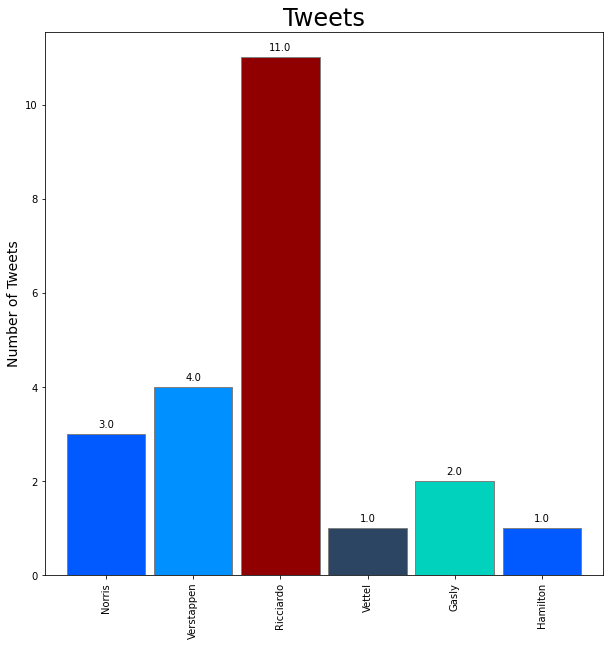

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('Counting_Results.csv', usecols = ['Driver', 'Total_number'])

    
# bar chart showing number of votes for each of the drivers
wykres=df.plot(kind='bar',x='Driver',y='Total_number', 
        width=0.9, 
        color= ['#005AFF','#0090FF','#900000','#2B4562','#00D2BE','#005AFF','#DC0000','#FFFFFF','#FF8700','#0090FF','#0600EF','#FF8700','#00D2BE','#DC0000','#FFFFFF','#006F62','#2B4562','#0600EF','#006F62','#900000'],
        edgecolor='grey',
        figsize=(10,10))

for p in wykres.patches:
    wykres.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.ylabel("Number of Tweets",fontsize=14)
plt.xlabel("")
plt.title('Tweets',fontsize=24) 
wykres.legend_.remove()

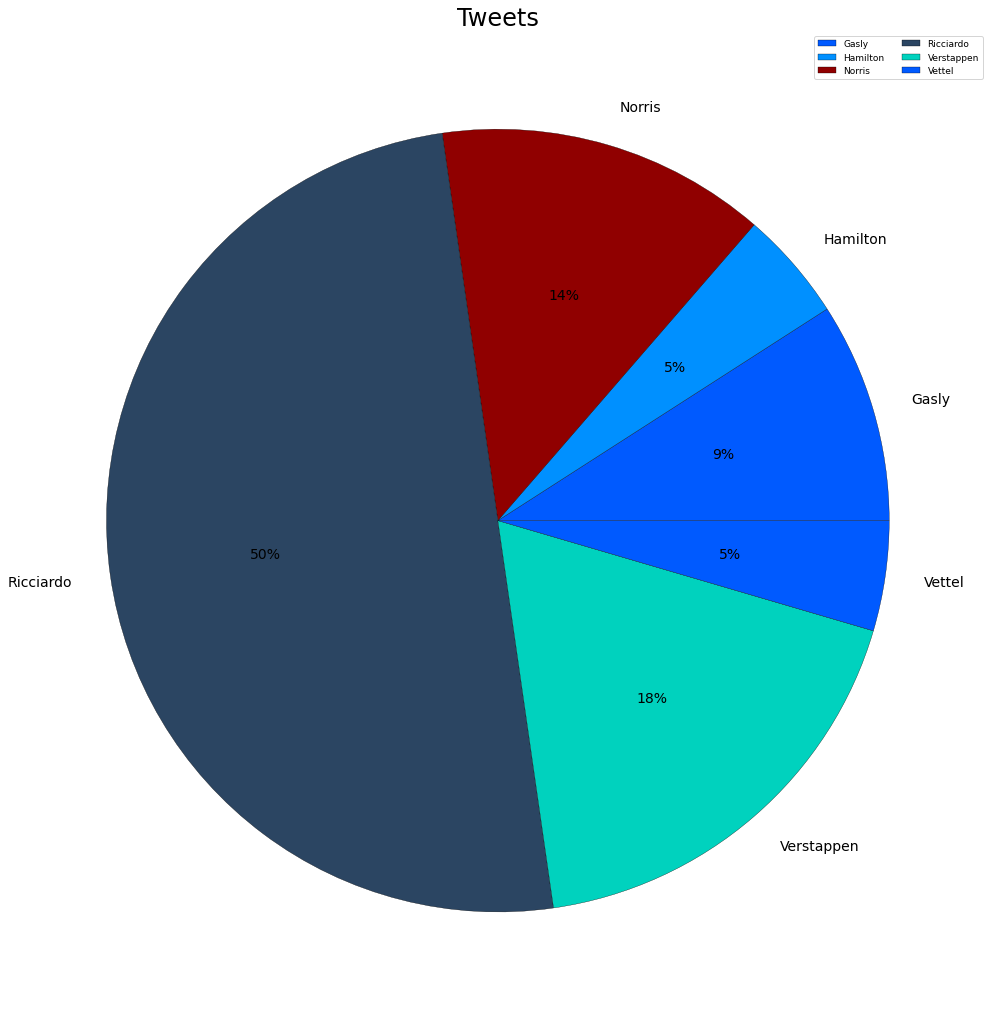

In [2]:
#pie chart
df.groupby(['Driver']).sum().plot(kind='pie', y='Total_number', autopct='%1.0f%%',
                                figsize=(18,18),
                                colors = ['#005AFF','#0090FF','#900000','#2B4562','#00D2BE','#005AFF','#DC0000','#FFFFFF','#FF8700','#0090FF','#0600EF','#FF8700','#00D2BE','#DC0000','#FFFFFF','#006F62','#2B4562','#0600EF','#006F62','#900000'],
                                wedgeprops = {"edgecolor" : "black", 'linewidth': 0.3, 'antialiased': True},
                                fontsize=14)
leg = plt.legend( loc = 'upper right',prop={'size': 9},ncol=2)
tyt=plt.title('Tweets',fontsize=24)   
lab=plt.ylabel("")

In [8]:
#podium dataframe
df1=df.nlargest(n=3, columns=['Total_number'])
# add a column
df1.insert(2, "Podium", [1,2,3], True)
  
# Check the result
df1

,Driver,Total_number,Podium
2,Ricciardo,11,1
1,Verstappen,4,2
0,Norris,3,3


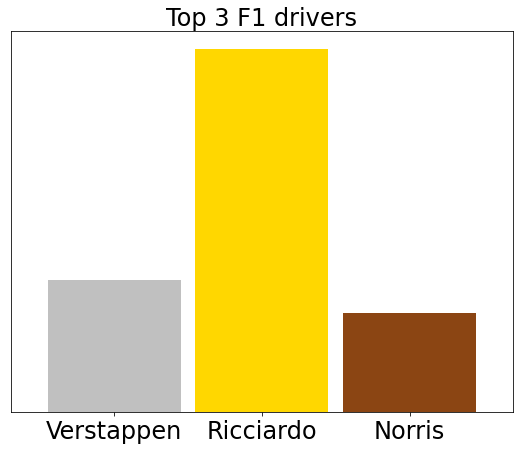

In [7]:
#podium chart
podium=df1.sort_values('Podium', ascending = True).plot(kind='bar',x='Driver',y='Total_number',
        figsize=(9,7),
        width=0.9,
        color= ['silver','gold','saddlebrown'],
        )


plt.xticks(x='Driver',rotation=0,fontsize=24)



plt.xlabel
plt.ylabel("Number of Tweets",fontsize=14)
plt.xlabel("")
plt.title('Top 3 F1 drivers',fontsize=24)
podium.get_yaxis().set_visible(False)
podium.legend_.remove()